Top trials by mean score:
 fold          1         2         3         4         5      mean
trial                                                            
34     0.799141  0.808680  0.798014  0.792507  0.790986  0.797866
66     0.791600  0.811404  0.793696  0.796053  0.791449  0.796840
101    0.793808  0.798087  0.798757  0.795287  0.796362  0.796460
86     0.792659  0.802518  0.798659  0.794111  0.794123  0.796414
27     0.792867  0.801229  0.800144  0.804118  0.783096  0.796291
60     0.794373  0.799198  0.795350  0.794033  0.793498  0.795290
28     0.784880  0.803674  0.805199  0.791529  0.790759  0.795208
30     0.786949  0.798051  0.804062  0.792656  0.790960  0.794536
42     0.784178  0.803654  0.800464  0.790479  0.793664  0.794488
3      0.798600  0.798479  0.797537  0.788407  0.788750  0.794355


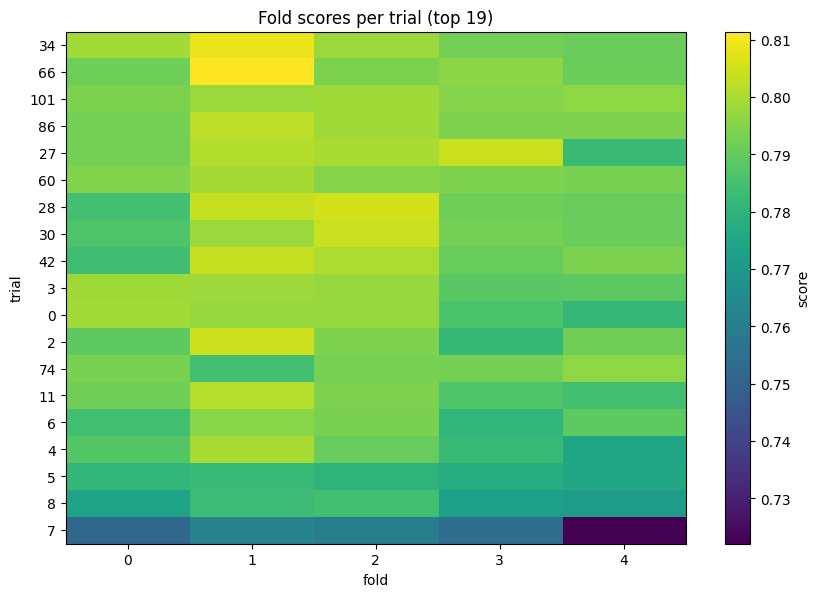

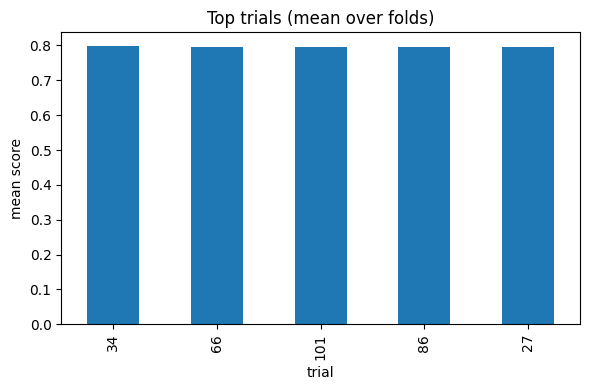

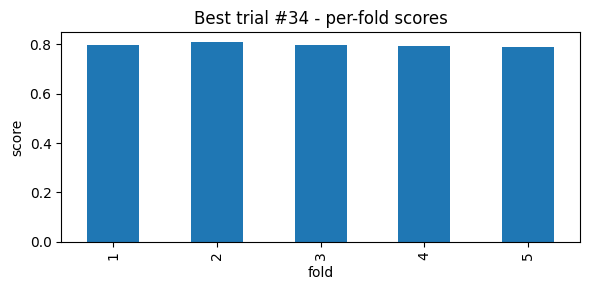

In [3]:
# ==== 設定 ====
STORAGE = "sqlite:///lstmgru_tuning.db"
STUDY   = "imu_tuning"

import optuna, pandas as pd, numpy as np, matplotlib.pyplot as plt
from optuna.trial import TrialState

study = optuna.load_study(study_name=STUDY, storage=STORAGE)

# 1) user_attr から fold_scores(list[float]) を収集
rows = []
for t in study.get_trials(states=(TrialState.COMPLETE,)):
    fs = t.user_attrs.get("fold_scores", None)
    if isinstance(fs, (list, tuple)) and len(fs) > 0:
        for i, s in enumerate(fs, start=1):  # i=fold番号(1始まり)
            rows.append({"trial": t.number, "fold": i, "score": float(s), "objective": t.value})

df = pd.DataFrame(rows)
assert not df.empty, "fold_scores が見つかりません。trial.set_user_attr('fold_scores', list) を確認してください。"

# 2) ピボット（trial×fold）
pv = df.pivot_table(index="trial", columns="fold", values="score", aggfunc="mean")
pv["mean"] = pv.mean(axis=1)

# 3) 上位を確認
top = pv.sort_values("mean", ascending=False)
print("Top trials by mean score:\n", top.head(10))

# 4) ヒートマップ（上位20試行）
top_k = min(20, len(top))
hm = top.iloc[:top_k, :-1]  # 平均列を除外
plt.figure(figsize=(10, max(4, 0.35*top_k)))
plt.imshow(hm, aspect="auto")
plt.title(f"Fold scores per trial (top {top_k})")
plt.xlabel("fold")
plt.ylabel("trial")
plt.colorbar(label="score")
plt.yticks(range(top_k), hm.index.to_list())
plt.show()

# 5) 上位5試行の平均スコア棒グラフ
plt.figure(figsize=(6,4))
top["mean"].head(min(5, len(top))).plot(kind="bar")
plt.ylabel("mean score")
plt.title("Top trials (mean over folds)")
plt.tight_layout()
plt.show()

# 6) ベスト試行の fold別スコアを個別に可視化（任意）
best_trial = int(top.index[0])
plt.figure(figsize=(6,3))
pv.loc[best_trial].drop("mean").plot(kind="bar")
plt.ylabel("score")
plt.title(f"Best trial #{best_trial} - per-fold scores")
plt.tight_layout()
plt.show()

# （必要ならCSV出力）
# pv.to_csv("fold_scores_pivot.csv")
